# Image Feature Aggregation with Attention Mechanisms

The purpose of this exercise is to demonstrate building self-attention and multihead-attention from scratch using images only. Here we
implement a simplified version of self-attention and multi-head attention mechanisms to aggregate features from different regions of an image, that we can later visualize. Instead of training a model, we work with pre-extracted image features and use attention to emphasize important parts of the image for a specific task.


In [1]:
!pip install ftfy regex tqdm

In [3]:
import os
os.chdir('CLIP')

In [2]:
!pip install --upgrade setuptools

In [4]:
!pip install git+https://github.com/openai/CLIP.git --use-pep517

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hz9kqydc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hz9kqydc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6c2b03fa9154696636e2a692bf7f89b67a446f4a40f1b131821b5df423158e3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ck62jbod/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Load pre-extracted image features

Use CLIP models, to use a pre-extracted feature maps for an image.

In [5]:
import torch
from CLIP import clip 
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)




100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 131MiB/s]


In [94]:
image_path = "image_fusion/daisy.jpg"
daisy = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
#text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

In [95]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [114]:
daisy_image_embedding = model.encode_image(daisy)

In [115]:
daisy_image_embedding.size()

torch.Size([1, 512])

In [98]:
daisy.size()

torch.Size([1, 3, 224, 224])

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [100]:
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Create image patches to simulate tokens for the attention mechanism

In [101]:
def create_tokens(embeddings, num_tokens=16):
    # Reshape (1, 512) to (16, 32)
    return embeddings.reshape(num_tokens, -1)

In [102]:
tokens = create_tokens(daisy_image_embedding)

# Implement self-attention mechanism
- Create query, key, and value matrices from the input features
- Compute attention scores and apply softmax
- Calculate weighted sum of values

In [103]:
def self_attention(features, d_k):
    N, D = features.shape
    
    # Create query, key, and value matrices
    W_q = np.random.randn(D, d_k)
    W_k = np.random.randn(D, d_k)
    W_v = np.random.randn(D, d_k)
    
    Q = np.dot(features, W_q)
    K = np.dot(features, W_k)
    V = np.dot(features, W_v)
    
    # Compute attention scores
    attention_scores = np.dot(Q, K.T) / np.sqrt(d_k)
    attention_weights = softmax(attention_scores, axis=-1)
    
    # Compute weighted sum
    output = np.dot(attention_weights, V)
    
    return output, attention_weights

# Implement multi-head attention mechanism
- Split input features into multiple heads
- Apply self-attention to each head independently
- Concatenate results from all heads
- Apply a linear transformation to get final output

In [104]:
def multi_head_attention(features, num_heads, d_k):
    N, D = features.shape
    d_head = D // num_heads
    
    # Split features into multiple heads
    heads = []
    for i in range(num_heads):
        head_features = features[:, i*d_head:(i+1)*d_head]
        head_output, _ = self_attention(head_features, d_k)
        heads.append(head_output)
    
    # Concatenate heads
    concatenated = np.concatenate(heads, axis=-1)
    
    # Apply linear transformation
    W_o = np.random.randn(D, D)
    output = np.dot(concatenated, W_o)
    
    return output

In [105]:
def visualize_attention(attention_weights):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Attention Weights')
    plt.show()

In [106]:
self_attention_output, attention_weights = self_attention(tokens.cpu().detach().numpy(), d_k=8)

In [107]:
multi_head_output = multi_head_attention(tokens.cpu().detach().numpy(), num_heads=4, d_k=8)

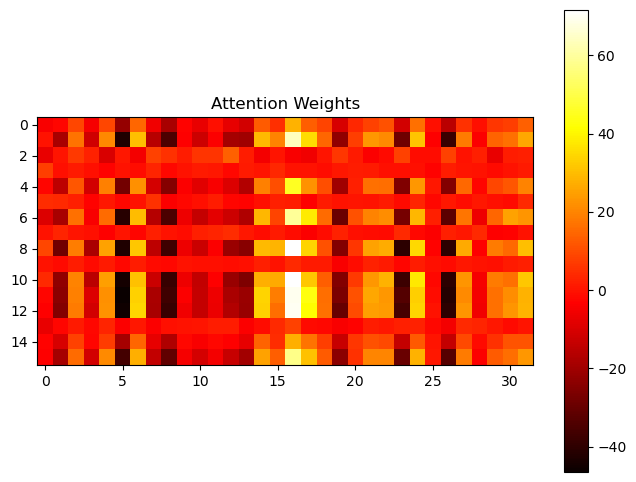

In [108]:
visualize_attention(multi_head_output)

## The multi-head outputs can serve as dense features from the image that maybe used for other downstream tasks. 

# Token importance visualization:

We can project the importance of each token back onto the original image. While not perfectly accurate, it can give an intuitive view of which image regions might be most important.

In [109]:


def visualize_token_importance(image_path, attention_weights):
    # Load and resize original image
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    
    # Compute token importance
    token_importance = attention_weights.mean(axis=0)
    
    # Create a heatmap of the same size as the image
    num_tokens = len(token_importance)
    heatmap_size = int(np.ceil(np.sqrt(num_tokens)))
    heatmap = np.zeros((heatmap_size, heatmap_size))
    
    for i in range(num_tokens):
        row = i // heatmap_size
        col = i % heatmap_size
        heatmap[row, col] = token_importance[i]
    
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Upsample heatmap to match image size
    heatmap = Image.fromarray(heatmap).resize((224, 224), Image.BICUBIC)
    heatmap = np.array(heatmap)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Display heatmap overlaid on original image
    ax2.imshow(original_image)
    im = ax2.imshow(heatmap, cmap='hot', alpha=0.5)
    ax2.set_title('Token Importance Heatmap')
    ax2.axis('off')
    
    # Add colorbar
    plt.colorbar(im, ax=ax2, label='Token Importance')
    
    plt.tight_layout()
    plt.show()


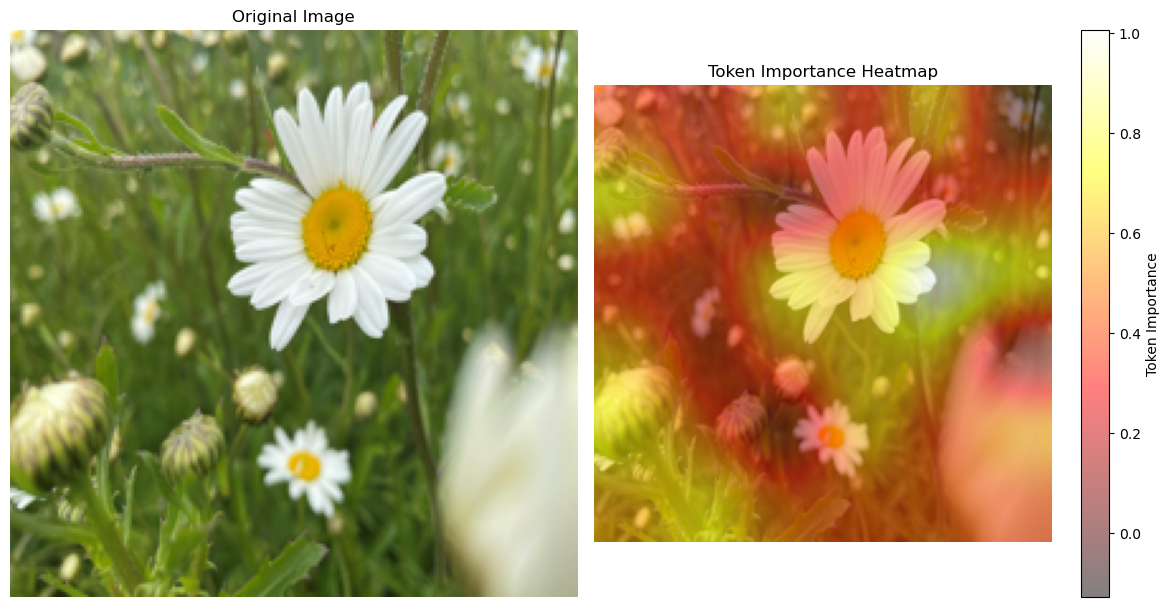

In [110]:
visualize_token_importance(image_path, multi_head_output)